<a href="https://colab.research.google.com/github/thamsuppp/MusicGenDL/blob/main/Applying_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prendiamo il mood dalla rete precedente

# Applying VAE to Generate Music in Specific Styles

In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

E: Package 'libfluidsynth1' has no installation candidate
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import glob
import numpy as np
import pandas as pd
import pretty_midi
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
import librosa.display
import matplotlib.pyplot as plt
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools
root_dir = 'drive/MyDrive/ColabNotebooks/AsItSounds'
data_dir = root_dir + '/Lakh Piano Dataset/lpd_5/lpd_5_cleansed'
music_dataset_lpd_dir = root_dir + '/Music Dataset/midis/lmd_matched'

**Getting MIDI and Song Metadata**

In [ ]:
# @title Helper Functions for MIDI Files, Genre File

RESULTS_PATH = os.path.join(root_dir, 'Lakh Piano Dataset', 'Metadata')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)


def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

# Load the midi npz file from the LMD cleansed folder
def get_midi_npz_path(msd_id, midi_md5):
    return os.path.join(data_dir,
                        msd_id_to_dirs(msd_id), midi_md5 + '.npz')

# Load the midi file from the Music Dataset folder
def get_midi_path(msd_id, midi_md5):
    return os.path.join(music_dataset_lpd_dir,
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

# Open the cleansed ids - cleansed file ids : msd ids
cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)
lpd_to_msd_ids = {a:b for a, b in zip(cleansed_ids[0], cleansed_ids[1])}
msd_to_lpd_ids = {a:b for a, b in zip(cleansed_ids[1], cleansed_ids[0])}

# Reading the genre annotations
genre_file_dir = os.path.join(root_dir, 'Lakh Piano Dataset', 'msd_tagtraum_cd1.cls')
ids = []
genres = []
with open(genre_file_dir) as f:
    line = f.readline()
    while line:
        if line[0] != '#':
          split = line.strip().split("\t")
          if len(split) == 2:
            ids.append(split[0])
            genres.append(split[1])
          elif len(split) == 3:
            ids.append(split[0])
            ids.append(split[0])
            genres.append(split[1])
            genres.append(split[2])
        line = f.readline()
genre_df = pd.DataFrame(data={"TrackID": ids, "Genre": genres})

genre_dict = genre_df.groupby('TrackID')['Genre'].apply(lambda x: x.tolist()).to_dict()

<ipython-input-4-8d7d5c8e64cd>:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)


**Objects that we need**

- cleansed_ids: dictionary of LPD file name : MSD file name
- lmd_metadata: list of dictionaries - each dict has a msd_id field to identify
- Get the lmd_file_name (actual path )

###Collegamento rete mood

Importiamo il modello

In [ ]:
import keras

# Loading the pretrained model doing face mood recognition
# It was made in keras

# model_faceEx_h5_path = root_dir +"/Saved Models/KDEF/full_kdef_VGG16_finetuned.h5"
model_faceEx_h5_path = "/content/drive/MyDrive/ColabNotebooks/AsItSounds/Saved Models/KDEF/full_kdef_VGG16_finetuned.h5"

model_mood = keras.models.load_model(model_faceEx_h5_path)

# Print a template summary
model_mood.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

We import the pickle file from which we take the pools for emotions

In [ ]:
import pickle
import random

with open('/content/drive/MyDrive/ColabNotebooks/AsItSounds/Face_samples/mood_dict.pkl', 'rb') as f:
    data = pickle.load(f)

print(data)

def get_random_keys_with_value(d, target_value, num_keys=20):
    # Filter the keys that have the specified value
    filtered_keys = [key for key, value in d.items() if value == target_value]

    # If the number of filtered keys is less than num_keys, return all filtered keys
    if len(filtered_keys) <= num_keys:
        return filtered_keys

    # Otherwise, randomly select num_keys
    random_keys = random.sample(filtered_keys, num_keys)

    return random_keys

# is an array made with (class, [vector of relative msd_ids])
emotion=[]
for i in [0,2,3,4,5,6]:
    value=get_random_keys_with_value(data,i)
    emotion.append((i,value))
print(len(emotion[2][1]))



{'TRMMXYX128F42946B5': 3, 'TRMMDLW128F1471733': 4, 'TRMJUPD128F92E7217': 5, 'TRMJIPB128F42701FE': 4, 'TRMXMAD128F92FDE6C': 3, 'TRMXGDP12903CEAAAE': 3, 'TRMXLIO12903C99041': 3, 'TRMXWXT128F426BF49': 3, 'TRMXCHV128F92F965C': 4, 'TRMHNXM128F933E6DE': 3, 'TRMHZDA128F42950E1': 3, 'TRMHVXG128F9321308': 4, 'TRMHVFF128E078AFCD': 5, 'TRMDEZV128F932FBD0': 4, 'TRMDIWW128F92EC784': 4, 'TRMDSZE128F428CD41': 4, 'TRMOEJD128F149598F': 4, 'TRMOWWF12903CBF6E8': 4, 'TRMOVID128F422B8EB': 4, 'TRMNSIO12903CC0FEE': 4, 'TRMEHFC128F422D986': 4, 'TRMEYIR12903C9ABB9': 3, 'TRMEAOD128F92D0C94': 3, 'TRMTTVV12903CAAE2B': 4, 'TRMTLEF128E0786194': 2, 'TRMTATV12903CA4A32': 3, 'TRMIDRJ12903CE83A2': 4, 'TRMIZZM128F427F1A7': 4, 'TRMIZVH128F42A52F6': 4, 'TRMGHSX128E0785D11': 3, 'TRMGDGG128E078B3E2': 4, 'TRMGAAS128F93141FA': 4, 'TRMGVFR128F42667B5': 6, 'TRMGQAF128E078E635': 3, 'TRMPGKD128F9330F9D': 3, 'TRMPYTL128F428FFA7': 4, 'TRMPLJB128F92F5320': 4, 'TRMPCYV128F148F2F5': 3, 'TRMPKJE128F426F74C': 3, 'TRMYPOA128F92C97B3': 3,

We define how to get the song from the emotion-related pool of 20 songs for each emotion. Here we perform a matching between the emotion output from the network clasifying images and the emotion from the song dataset.

In [ ]:

def song_selection(image, model_for_image):

  # class predicted by the model
  mood_class = model_for_image.predict(image)
  print(mood_class[0])
  mood_class = np.argmax(mood_class[0])
  print(mood_class)
  # Match for emotion dataset
  # Emotion is a list of six tuple, so from 0 onwards it needs to adjust indexes (i-1)
  # for ex, each AF songs will be in emotion[2-1][1]

  # AF = 2
  # AN = 0
  # DI = 1 there is not a single song with this label :(, I will always choose angry
  # HA = 3
  # NE = 4
  # SA = 5
  # SU = 6

  map_class_mood = {0: 'AF',  1 :'AN',2: 'DI',3: 'HA',4: 'NE',5: 'SA',6: 'SU'}
  pools = {'AF': emotion[1][1],'AN': emotion[0][1],'DI': emotion[0][1],'HA': emotion[2][1],'NE': emotion[3][1], 'SA': emotion[4][1], 'SU': emotion[5][1]}

  generator_pool = None

  for mood in ['AF','AN','DI','HA','NE','SA','SU']:

    # if the aforementioned class is equal to a pool
    if(map_class_mood[mood_class]==mood):

      chosen_emotion = map_class_mood[mood_class]
      chosen_pool = pools[chosen_emotion]

      chosen_id = random.randint(0,20)
      chosen_song = chosen_pool[chosen_id]
      break

  return chosen_song



map_class_mood = {0: 'AF',  1 :'AN',2: 'DI',3: 'HA',4: 'NE',5: 'SA',6: 'SU'}
pools = {'AF': emotion[1][1],'AN': emotion[0][1],'DI': emotion[0][1],'HA': emotion[2][1],'NE': emotion[3][1], 'SA': emotion[4][1], 'SU': emotion[5][1]}

print(pools)


{'AF': ['TRPJRWY12903CE5772', 'TREYALU128F933BBB7', 'TRRFZMC128F14A0B78', 'TRUKHZD128F92DF70A', 'TRRULOY128F4273A39', 'TRUIWFY128F92F6B9E', 'TRFTRKT128F427D70D', 'TRMTLEF128E0786194', 'TRLNYUR128F145F6EE', 'TRNSGVZ128F93267E9', 'TROWZEU128F4279F0D', 'TRKTDXK128E0780E4A', 'TRAZYWP128F92E53F3', 'TRAXVGE128E0783F1D', 'TRELVDA128F14995FA', 'TRCMGKO128F42ACC1A', 'TRPCKQK128F424E12C', 'TRYLGJE12903CCA7BE', 'TRCAHHI128F92F0305', 'TRARIHF12903CB2756'], 'AN': ['TRGJQJE128F42A807B', 'TRDYCRY128F42BCE60', 'TRBCLWV128F1471333', 'TRHPCUO128F92D3135', 'TRPDHHT12903CAE43E', 'TRXGXDS12903CA7B6B', 'TRVZJXM12903CC4483', 'TRDCKGI128F1496A7A', 'TRRYGYC12903CF622A', 'TRJXSCA12903CF83AC', 'TRPPZXC12903D067C9', 'TRFMNKP128F428ADC0', 'TRTFRMJ128F93043F9', 'TRUFMQN128F9306CAF', 'TRSRBER128F931F5CE', 'TRPMFRG128F92CB73C', 'TRJQFYG12903C9B2FB', 'TRTWFKE128EF35F93B', 'TRCHYLU128F92CA525', 'TRQPHIR128E07911FC'], 'DI': ['TRGJQJE128F42A807B', 'TRDYCRY128F42BCE60', 'TRBCLWV128F1471333', 'TRHPCUO128F92D3135', 'TRPDHHT

In [ ]:
import pickle

with open('/content/pools.pkl', 'wb') as f:
    pickle.dump(pools, f)

(1280, 1210, 3)


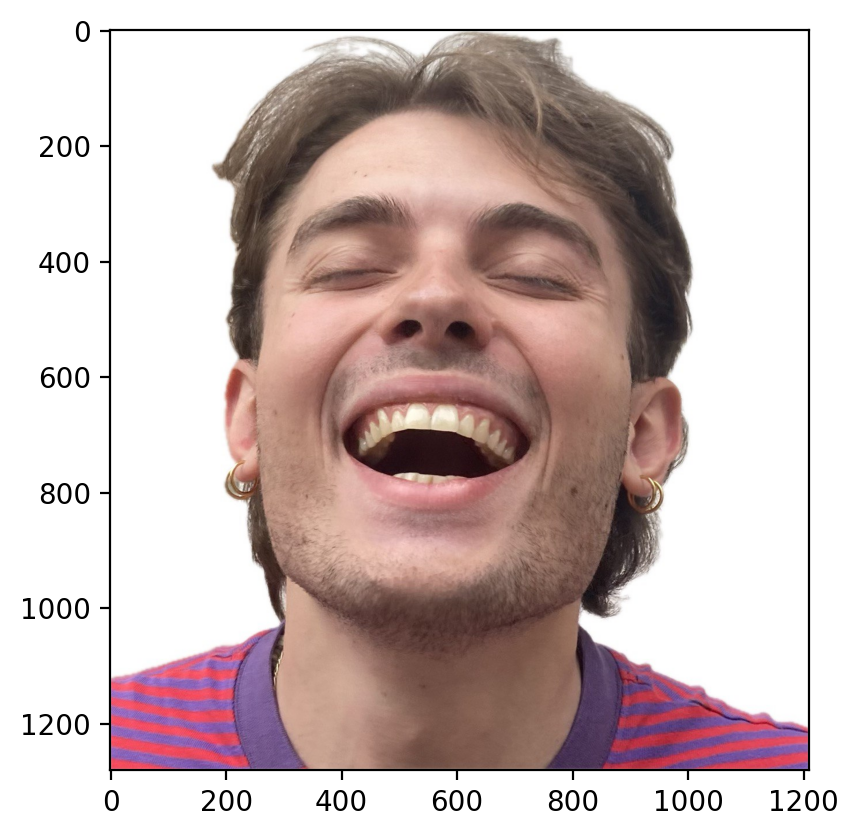

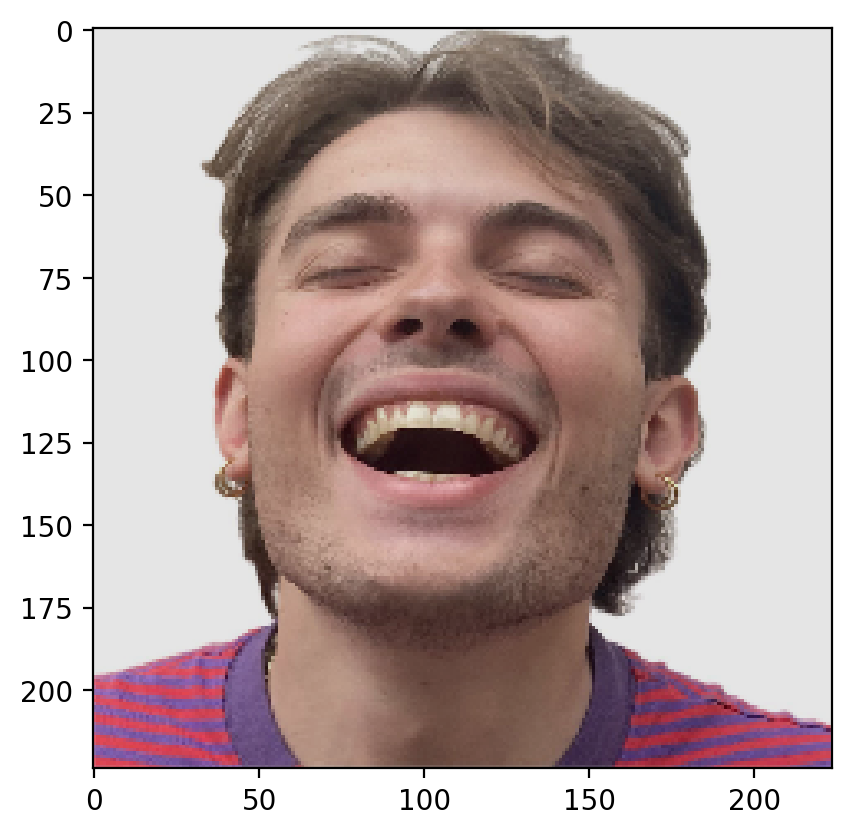

(224, 224, 3)
1/1 [==============================] - 3s 3s/step
[3.2984084e-01 4.1092417e-04 2.7962973e-02 6.0356200e-01 1.6527019e-03
 1.3487642e-02 2.3082949e-02]
3
['TRAFSAP128E0780ECF']


In [ ]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import cv2

img_rows=224
img_cols=224
img_channels=3

# Image loading and preprocessing
img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/AsItSounds/Face_samples/happy_Luigi.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
plt.imshow(img_rgb)
plt.show()

resized_images = cv2.resize(img_rgb, (224, 224))
resized_images = resized_images / 255.0

# Grey background
background = np.full_like(resized_images, [0.5, 0.5, 0.5])

# Brightness reduction (optional)
resized_images *= 0.9

# Combina immagine e sfondo
resized_images = cv2.addWeighted(resized_images, 1, background, 0, 0)

# Restores shape for compatibility
img = np.reshape(resized_images, (-1, img_rows, img_cols, img_channels))

# View modified image
plt.imshow(resized_images)
plt.show()


# Checking the new shape of the batch of images
print(resized_images.shape)
filtered_msd_ids=[]
filtered_msd_id = song_selection(img, model_mood)
filtered_msd_ids.append(filtered_msd_id)
print(filtered_msd_ids)

### Creating pianorolls

In [ ]:
combined_pianorolls = []
i = 0
for msd_file_name in filtered_msd_ids:

  print(msd_file_name)
  lpd_file_name = msd_to_lpd_ids[msd_file_name]
  # Get the NPZ path
  npz_path = get_midi_npz_path(msd_file_name, lpd_file_name)
  multitrack = pypianoroll.load(npz_path)
  multitrack.set_resolution(2).pad_to_same()

  # Piano, Guitar, Bass, Strings, Drums
  # Splitting into different parts

  parts = {'piano_part': None, 'guitar_part': None, 'bass_part': None, 'strings_part': None, 'drums_part': None}
  song_length = None
  empty_array = None
  has_empty_parts = False
  for track in multitrack.tracks:
    if track.name == 'Drums':
      parts['drums_part'] = track.pianoroll
    if track.name == 'Piano':
      parts['piano_part'] = track.pianoroll
    if track.name == 'Guitar':
      parts['guitar_part'] = track.pianoroll
    if track.name == 'Bass':
      parts['bass_part'] = track.pianoroll
    if track.name == 'Strings':
      parts['strings_part'] = track.pianoroll
    if track.pianoroll.shape[0] > 0:
      empty_array = np.zeros_like(track.pianoroll)

  for k,v in parts.items():
    if v.shape[0] == 0:
      parts[k] = empty_array.copy()
      has_empty_parts = True

  # Stack all together - Piano, Guitar, Bass, Strings, Drums
  combined_pianoroll = torch.tensor([parts['piano_part'], parts['guitar_part'], parts['bass_part'], parts['strings_part'], parts['drums_part']])
  combined_pianorolls.append(combined_pianoroll)

TRYUVJD128F9345163


In [ ]:
combined_pianoroll.size()

torch.Size([5, 944, 128])

In [ ]:
# Saving
pianoroll_lengths = [e.size()[1] for e in combined_pianorolls]
combined_pianorolls = torch.hstack(combined_pianorolls)

torch.save(combined_pianorolls, os.path.join(root_dir, 'Lakh Piano Dataset', 'conditional_pianorolls.pt'))
pianoroll_lengths = torch.tensor(pianoroll_lengths)
torch.save(pianoroll_lengths, os.path.join(root_dir, 'Lakh Piano Dataset', 'conditional_pianorolls_lengths.pt'))

In [ ]:
# Loading the entire dataset
combined_pianorolls = torch.load(os.path.join(root_dir, 'Lakh Piano Dataset', 'conditional_pianorolls.pt'))
pianoroll_lengths = torch.load(os.path.join(root_dir, 'Lakh Piano Dataset', 'conditional_pianorolls_lengths.pt'))
pianoroll_lengths = pianoroll_lengths.numpy()
pianoroll_cum_lengths = pianoroll_lengths.cumsum()

# Normalize
combined_pianorolls = combined_pianorolls / 127.0
print(combined_pianorolls.shape)

torch.Size([5, 944, 128])


In [ ]:
# Remake the list of pianorolls - ensuring all songs are multiple of 32
pianorolls_list = []
pianorolls_list.append(combined_pianorolls[:, :(pianoroll_cum_lengths[0] - pianoroll_cum_lengths[0] % 32), :])
for i in range(len(pianoroll_cum_lengths) - 1):
  length = pianoroll_cum_lengths[i+1] - pianoroll_cum_lengths[i]
  # Get the nearest multiple of 32
  length_multiple = length - (length % 32)
  pianoroll = combined_pianorolls[:, pianoroll_cum_lengths[i]:(pianoroll_cum_lengths[i] + length_multiple), :]
  pianorolls_list.append(pianoroll)

# Combine the pianorolls again
combined_pianorolls = torch.hstack(pianorolls_list)

**Creating Music Dataset**

In [ ]:
# Creating dataset and dataloader
from torch.utils.data import Dataset, DataLoader

In [ ]:
# @title Old Datasets used for Training

# Dataset which only returns sequences which are multiples of 32
class CombinedDataset(Dataset):
  def __init__(self, pianorolls, instrument_id):
    self.data = pianorolls
    self.length = int(pianorolls.size(1) / 32)
    self.instrument_id = instrument_id

  def __getitem__(self, index):
    sequence = self.data[self.instrument_id, (index * 32):((index+1) * 32), :]
    return sequence

  def __len__(self):
    return self.length

# Melody-conditional dataset NEW - returns BOTH the previous harmony, and current melody, and current harmony
# only outputs samples with all tracks non-empty
class ConditionalDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 1000, seq_length = 50, instrument = 'guitar'):

    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length
    self.instrument = instrument

  def __getitem__(self, index):
    # Choose a random song id
    valid_sequence = False

    while valid_sequence == False:
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]

      # Choose a random start window
      start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
      start_time = start_time - (start_time % 32)

      # train_sequence: 1 (piano) x seq_length x 128
      piano_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]

      if self.instrument == 'guitar':
        past_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][1, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      elif self.instrument == 'bass':
        past_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][2, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      elif self.instrument == 'strings':
        past_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][3, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      elif self.instrument == 'drums':
        past_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]
        target_sequence = self.data[song_id][4, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
      else:
        past_sequence = None
        target_sequence = None

      if piano_sequence.sum() != 0 and past_sequence.sum() != 0 and target_sequence.sum() != 0:
        valid_sequence = True
      else:
        if random.random() < 0.1:
          valid_sequence = True

    return piano_sequence, past_sequence, target_sequence
  def __len__(self):
    return self.length

# Melody prediction dataset - predict the next melody given the current melody
class MelodyDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):
    # Choose a random song id
    song_id = random.randint(0, self.n_songs - 1)
    song_length = self.data[song_id].size()[1]
    # Choose a random start window
    start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
    start_time = start_time - (start_time % 32)
    # train_sequence: 1 (piano) x seq_length x 128
    train_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
    # target_sequence: 1 (piano) x seq_length x 128
    target_sequence = self.data[song_id][0, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
    return train_sequence, target_sequence

  def __len__(self):
    return self.length

### VAE Execution

In [ ]:
# @title VAE Helper Functions

def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]

    This uses mu_p = 0 and sigma_p = 1, which simplifies the log(p(zs)) term to
    just -1/2*(zs**2)
    """
    b, n, k = zs.size()
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs**2)
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))

def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))

def rsample(phi, n_samples):
    """Sample z ~ q(z;phi)
    Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
    entries of each row of phi are the mean of q, and phi[:,-1] is the log
    standard deviation
    """
    b, kplus1 = phi.size()
    k = kplus1-1
    mu, sig = phi[:, :-1], phi[:,-1].exp()
    eps = torch.randn(b, n_samples, k, device=phi.device)
    return eps*sig.view(b,1,1) + mu.view(b,1,k)

In [ ]:
# @title ConvVAE Architecture

class ConvVAE(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvVAE, self).__init__()

        # Define the recognition model (encoder or q) part
        # Input size: num_channels (1) x seq_length (32) x n_pitches (128)
        self.q_conv_1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.q_conv_2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 4), stride = (4, 4))
        self.q_conv_3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (2, 8), stride = (2, 8))
        self.q_fc_phi = nn.Linear(256, K+1)

        # Define the generative model (decoder or p) part
        self.p_fc_upsample = nn.Linear(K, 256)
        self.p_deconv_1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = (2, 8), stride = (2, 8))
        self.p_deconv_2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (4, 4), stride = (4, 4))
        self.p_deconv_3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = (4, 4), stride = (4, 4))

        # Define a special extra parameter to learn scalar sig_x for all pixels
        self.log_sig_x = nn.Parameter(torch.zeros(()))

    def infer(self, x):
        """Map (batch of) x to (batch of) phi which can then be passed to
        rsample to get z
        """
        x = x.unsqueeze(1)
        s = F.relu(self.q_conv_1(x))
        s = F.relu(self.q_conv_2(s))
        s = F.relu(self.q_conv_3(s))
        # Flatten s
        flat_s = s.view(s.size()[0], -1)
        phi = self.q_fc_phi(flat_s)
        return phi

    def generate(self, zs):
        """Map [b,n,k] sized samples of z to [b,n,p] sized images
        """
        # Note that for the purposes of passing through the generator, we need
        # to reshape zs to be size [b*n,k]
        b, n, k = zs.size()
        s = zs.view(b*n, -1)
        # Unflatten
        s = F.relu(self.p_fc_upsample(s)).unsqueeze(2).unsqueeze(3)
        s = F.relu(self.p_deconv_1(s))
        s = F.relu(self.p_deconv_2(s))
        s = self.p_deconv_3(s)
        mu_xs = s.view(b, n, -1)
        return mu_xs

    def forward(self, x):
        # VAE.forward() is not used for training, but we'll treat it like a
        # classic autoencoder by taking a single sample of z ~ q
        phi = self.infer(x)
        zs = rsample(phi, 1)
        return self.generate(zs).view(x.size())

    def elbo(self, x, n=1):
        """Run input end to end through the VAE and compute the ELBO using n
        samples of z
        """
        phi = self.infer(x)
        zs = rsample(phi, n)
        mu_xs = self.generate(zs)
        return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)

In [ ]:
# @title Conditional and Melody NN Architectures

# Conditional NN - uses current melody and previous harmony's LATENT vectors to predict next harmony's LATENT vectors
class ConditionalNN(nn.Module):
    def __init__(self, K):
        super(ConditionalNN, self).__init__()

        self.fc1 = nn.Linear(2*K, 128)
        self.fc2 = nn.Linear(128, K)

    def forward(self, prev_harmony, melody):

      x = torch.cat((prev_harmony, melody), axis = 1)
      x = F.relu(self.fc1(x))
      out = self.fc2(x)
      return out

# Melody NN - uses previous melody's LATENT vectors to predict next melody's LATENT VECTORS
class MelodyNN(nn.Module):
    def __init__(self, K):
        super(MelodyNN, self).__init__()
        self.fc1 = nn.Linear(K, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, K)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      out = self.fc3(x)
      return out

### Using Trained VAEs and NNs to Generate Music

In [ ]:
# @title Load trained VAEs and NNs (Run me)

# Specify dimensionality of VAEs you want (K = 8, 16, 32, 64)
K = 16

# Load VAEs
model_name = 'VAE_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
piano_vae = ConvVAE(K=K).to(device)
piano_vae.load_state_dict(torch.load(save_path))
piano_vae.eval()

model_name = 'VAE_guitar_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
guitar_vae = ConvVAE(K=K).to(device)
guitar_vae.load_state_dict(torch.load(save_path))
guitar_vae.eval()

model_name = 'VAE_bass_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
bass_vae = ConvVAE(K=K).to(device)
bass_vae.load_state_dict(torch.load(save_path))
bass_vae.eval()

model_name = 'VAE_strings_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
strings_vae = ConvVAE(K=K).to(device)
strings_vae.load_state_dict(torch.load(save_path))
strings_vae.eval()

model_name = 'VAE_drums_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
drums_vae = ConvVAE(K=K).to(device)
drums_vae.load_state_dict(torch.load(save_path))
drums_vae.eval()

# Load Melody NN
model_name = 'VAE_NN_piano_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
melody_nn = MelodyNN(K = K).to(device)
melody_nn.load_state_dict(torch.load(save_path))
melody_nn.eval()

# Load Conditional NNs
model_name = 'VAE_NN_guitar_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
guitar_nn = ConditionalNN(K = K).to(device)
guitar_nn.load_state_dict(torch.load(save_path))
guitar_nn.eval()

model_name = 'VAE_NN_bass_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
bass_nn = ConditionalNN(K = K).to(device)
bass_nn.load_state_dict(torch.load(save_path))
guitar_nn.eval()

model_name = 'VAE_NN_strings_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
strings_nn = ConditionalNN(K = K).to(device)
strings_nn.load_state_dict(torch.load(save_path))
strings_nn.eval()

model_name = 'VAE_NN_drums_{}'.format(K)
save_path = os.path.join(root_dir, 'Saved Models', 'VAE', 'Large Data', model_name)
drums_nn = ConditionalNN(K = K).to(device)
drums_nn.load_state_dict(torch.load(save_path))
drums_nn.eval()

ConditionalNN(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
)

In [ ]:
# @title Generation Dataset

# all fields cannot be blank
class GenerationDataset(Dataset):
  def __init__(self, list_of_sequences, dataset_length = 32 * 10000, seq_length = 50):

    # Don't normalize anymore since it was done earlier
    self.data = list_of_sequences
    self.n_songs = len(list_of_sequences)
    self.seq_length = seq_length
    self.length = dataset_length

  def __getitem__(self, index):

    valid_sequence = False
    while valid_sequence == False:
      # Choose a random song id
      song_id = random.randint(0, self.n_songs - 1)
      song_length = self.data[song_id].size()[1]
      # Choose a random start window
      start_time = random.randint(0, song_length - self.seq_length * 2 - 2)
      start_time = start_time - (start_time % 32)
      # Check that every track is not empty
      piano_sequence = self.data[song_id][0, start_time:(start_time + self.seq_length), :]
      guitar_sequence = self.data[song_id][1, start_time:(start_time + self.seq_length), :]
      bass_sequence = self.data[song_id][2, start_time:(start_time + self.seq_length), :]
      strings_sequence = self.data[song_id][3, start_time:(start_time + self.seq_length), :]
      drums_sequence = self.data[song_id][4, start_time:(start_time + self.seq_length), :]

      if piano_sequence.sum() != 0 and guitar_sequence.sum() != 0 and bass_sequence.sum() != 0 \
      and strings_sequence.sum() != 0 and drums_sequence.sum() != 0:
        valid_sequence = True
      else:
        if random.random() < 0.1:
          valid_sequence = True

    train_sequence = self.data[song_id][:, start_time:(start_time + self.seq_length), :]
    target_sequence = self.data[song_id][:, (start_time + self.seq_length):(start_time + self.seq_length * 2), :]
    return train_sequence, target_sequence

  def __len__(self):
    return self.length

In [ ]:
# @title ExternalSongGenerationDataset

# all fields cannot be blank
class ExternalSongGenerationDataset(Dataset):
  def __init__(self, song_pianoroll, seq_length = 32):

    # Don't normalize anymore since it was done earlier
    self.data = song_pianoroll
    self.seq_length = seq_length
    self.length = int(song_pianoroll.size(1) / seq_length)

  def __getitem__(self, index):

    piano_sequence = self.data[0, (index*32):((index+1)*32), :]
    guitar_sequence = self.data[1, (index*32):((index+1)*32), :]
    bass_sequence = self.data[2, (index*32):((index+1)*32), :]
    strings_sequence = self.data[3, (index*32):((index+1)*32), :]
    drums_sequence = self.data[4, (index*32):((index+1)*32), :]

    return piano_sequence, guitar_sequence, bass_sequence, strings_sequence, drums_sequence

  def __len__(self):
    return self.length

In [ ]:
song_pianoroll = combined_pianorolls[0]
song_pianoroll = song_pianoroll / 127.0
print(song_pianoroll.shape)

torch.Size([928, 128])


In [ ]:

# @title Generate Latent Samples function
def generate_latent_samples(song_loader):

  # Get list of the song's latent vectors
  song_latent_list = {'piano': [], 'guitar': [], 'bass': [], 'strings': [], 'drums': []}
  piano_empty_added = False
  guitar_empty_added = False
  bass_empty_added  = False
  strings_empty_added = False
  drums_empty_added = False
  for piano_sequence, guitar_sequence, bass_sequence, strings_sequence, drums_sequence in song_loader:
    if piano_sequence.sum() != 0:
      piano_latent = piano_vae.infer(piano_sequence.to(device))[:, :-1]
      song_latent_list['piano'].append(piano_latent)
    elif piano_empty_added == False:
      piano_latent = piano_vae.infer(piano_sequence.to(device))[:, :-1]
      song_latent_list['piano'].append(piano_latent)
      piano_empty_added = True

    if guitar_sequence.sum() != 0:
      guitar_latent = guitar_vae.infer(guitar_sequence.to(device))[:, :-1]
      song_latent_list['guitar'].append(guitar_latent)
    elif guitar_empty_added == False:
      guitar_latent = guitar_vae.infer(guitar_sequence.to(device))[:, :-1]
      song_latent_list['guitar'].append(guitar_latent)
      guitar_empty_added = True

    if bass_sequence.sum() != 0:
      bass_latent = bass_vae.infer(bass_sequence.to(device))[:, :-1]
      song_latent_list['bass'].append(bass_latent)
    elif bass_empty_added == False:
      bass_latent = bass_vae.infer(bass_sequence.to(device))[:, :-1]
      song_latent_list['bass'].append(bass_latent)
      bass_empty_added = True

    if strings_sequence.sum() != 0:
      strings_latent = strings_vae.infer(strings_sequence.to(device))[:, :-1]
      song_latent_list['strings'].append(strings_latent)
    elif strings_empty_added == False:
      strings_latent = strings_vae.infer(strings_sequence.to(device))[:, :-1]
      song_latent_list['strings'].append(strings_latent)
      strings_empty_added = True

    if drums_sequence.sum() != 0:
      drums_latent = drums_vae.infer(drums_sequence.to(device))[:, :-1]
      song_latent_list['drums'].append(drums_latent)
    elif drums_empty_added == False:
      drums_latent = drums_vae.infer(drums_sequence.to(device))[:, :-1]
      song_latent_list['drums'].append(drums_latent)
      drums_empty_added = True

  return song_latent_list

In [ ]:
# Function that takes in previous length-32 5-instrument sequence, and generates a new length-32 5-instrument sequence
# Input_sequence: 5 x 32 x 128, vae_models: 5-tuple of the trained VAEs, nn_models: 5-tuple of trained NNs
# threshold as a % of the maximum output that we will keep the notes there (those under threshold will be moved to 0)
# if binarize = True, will set all remaining non-zero to max intensity
def generate_music_vae(sample, vae_models, nn_models, noise_sd = 0, threshold = 0.3, binarize = True, latent_samples = None, latent_sample_factor = 0.5):

  piano_vae, guitar_vae, bass_vae, strings_vae, drums_vae = vae_models
  melody_nn, guitar_nn, bass_nn, strings_nn, drums_nn = nn_models

  piano, guitar, bass, strings, drums = sample[0, :, :], sample[1, :, :], sample[2, :, :], sample[3, :, :], sample[4, :, :]

  # Convert all part from image space to latent space - {instr}_latent: batch_size x K
  piano_latent = piano_vae.infer(piano.unsqueeze(0).to(device))[:, :-1]
  guitar_latent = guitar_vae.infer(guitar.unsqueeze(0).to(device))[:, :-1]
  bass_latent = bass_vae.infer(bass.unsqueeze(0).to(device))[:, :-1]
  strings_latent = strings_vae.infer(strings.unsqueeze(0).to(device))[:, :-1]
  drums_latent = drums_vae.infer(drums.unsqueeze(0).to(device))[:, :-1]

  if latent_samples: # Choose a random
    piano_latent_sample = random.choice(latent_samples['piano'])
    guitar_latent_sample = random.choice(latent_samples['guitar'])
    bass_latent_sample = random.choice(latent_samples['bass'])
    strings_latent_sample = random.choice(latent_samples['strings'])
    drums_latent_sample = random.choice(latent_samples['drums'])

    # Interpolate between the past latent and sample latent
    piano_latent = latent_sample_factor * piano_latent_sample + (1-latent_sample_factor) * piano_latent
    piano_latent = latent_sample_factor * guitar_latent_sample + (1-latent_sample_factor) * guitar_latent
    piano_latent = latent_sample_factor * bass_latent_sample + (1-latent_sample_factor) * bass_latent
    piano_latent = latent_sample_factor * strings_latent_sample + (1-latent_sample_factor) * strings_latent
    piano_latent = latent_sample_factor * drums_latent_sample + (1-latent_sample_factor) * drums_latent


  # Use melody NN to convert past piano latent to next piano latent - piano_next_latent: batch_size x K
  piano_next_latent = melody_nn(piano_latent)
  # Add some noise
  random_noise = torch.randn_like(piano_next_latent) * noise_sd
  piano_next_latent = piano_next_latent + random_noise

  # Use conditional NNs to convert piano latent to instrument latent, and add noise - {istr})_next_latent: batch_size x K
  guitar_next_latent = guitar_nn(guitar_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd
  bass_next_latent = bass_nn(bass_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd
  strings_next_latent = strings_nn(strings_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd
  drums_next_latent = drums_nn(drums_latent, piano_next_latent) + torch.randn_like(piano_next_latent) * noise_sd

  # Generate new samples given new latent
  piano_next = piano_vae.generate(piano_next_latent.unsqueeze(0)).view(1, 32, 128)
  guitar_next = guitar_vae.generate(guitar_next_latent.unsqueeze(0)).view(1, 32, 128)
  bass_next = bass_vae.generate(bass_next_latent.unsqueeze(0)).view(1, 32, 128)
  strings_next = strings_vae.generate(strings_next_latent.unsqueeze(0)).view(1, 32, 128)
  drums_next = drums_vae.generate(drums_next_latent.unsqueeze(0)).view(1, 32, 128)

  creation = torch.cat((piano_next, guitar_next, bass_next, strings_next, drums_next), dim = 0)
  creation[creation < threshold] = 0

  if binarize == True:
    creation[creation > 0] = 0.8

    # Quieten the strings
    creation[3, :, :] = creation[3, :, :] * 0.75

  return creation

In [ ]:
vae_models = (piano_vae, guitar_vae, bass_vae, strings_vae, drums_vae)
nn_models = (melody_nn, guitar_nn, bass_nn, strings_nn, drums_nn)
sample = combined_pianorolls[:, 320:352]

#Prende la canzone di partenza
song_dataset = ExternalSongGenerationDataset(combined_pianorolls, seq_length = 32)
song_loader = DataLoader(song_dataset, batch_size = 1, shuffle = False)
song_latent_list = generate_latent_samples(song_loader)

# Code to essentially recurrently generate music
prediction_steps = 8
generated_track = torch.zeros((5, 32 * (prediction_steps + 1), 128)).to(device)
generated_track[:, :32, :] = sample

for i in range(1, prediction_steps + 1):
  sample = generate_music_vae(sample, vae_models, nn_models, noise_sd = 1, threshold = 0.2, binarize = True, latent_samples = song_latent_list, latent_sample_factor = 0.5)
  generated_track[:,32*i:32*(i+1) , :] = sample

[<Axes: xlabel='time (beat)', ylabel='Piano\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Guitar\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Bass\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Strings\n\npitch'>,
 <Axes: xlabel='time (beat)', ylabel='Drums\n\npitch'>]

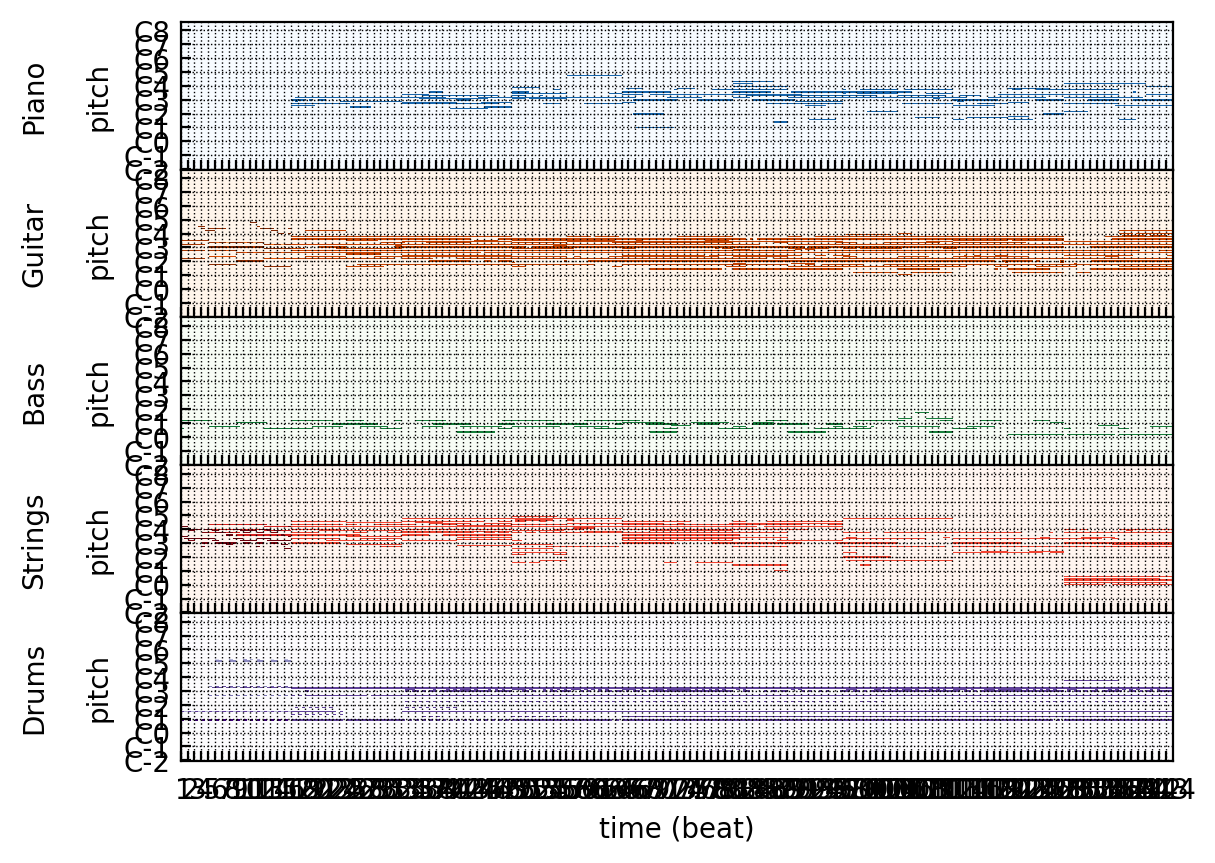

In [ ]:
# Only un-normalize here
generated_track_out = generated_track * 127
# Convert predictions into the multitrack pianoroll
piano_track = pypianoroll.StandardTrack(name = 'Piano', program = 0, is_drum = False, pianoroll = generated_track_out[0, :, :].detach().cpu().numpy())
guitar_track = pypianoroll.StandardTrack(name = 'Guitar', program = 24, is_drum = False, pianoroll = generated_track_out[1, :, :].detach().cpu().numpy())
bass_track = pypianoroll.StandardTrack(name = 'Bass', program = 32, is_drum = False, pianoroll = generated_track_out[2, :, :].cpu().detach().numpy())
strings_track = pypianoroll.StandardTrack(name = 'Strings', program = 48, is_drum = False, pianoroll = generated_track_out[3, :, :].cpu().detach().numpy())
drums_track = pypianoroll.StandardTrack(name = 'Drums', is_drum = True, pianoroll = generated_track_out[4, :, :].cpu().detach().numpy())
generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 2, tracks = [piano_track, guitar_track, bass_track, strings_track, drums_track])
generated_multitrack.plot()

In [ ]:
!apt-get install pyfluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package pyfluidsynth


In [ ]:
generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)

In [ ]:
generated_path = os.path.join(root_dir, 'GeneratedMidiFromVAE', 'conditioned_vae_mj.mid')
pypianoroll.write(generated_path, generated_multitrack)

In [ ]:
# Generate VAE (old function)

def generate_samples_vae(samples, instrument_vae, noise_sd):
  # Expects samples: batch_size x 32 x 128
  batch_size = samples.size(0)
  # Convert samples array into latent vectors
  latent = instrument_vae.infer(samples.to(device))[:, :-1]
  # Add some random noise
  random_noise = torch.randn_like(latent) * noise_sd
  latent_after_noise = latent + random_noise
  # Convert latent samples into array
  generated_samples = instrument_vae.generate(latent_after_noise.unsqueeze(0)).squeeze(0).view(batch_size, 32, 128)
  return generated_samples